In [1]:
!pip install numpy

In [2]:
import pydicom 
import os 
import pandas as pd 
import numpy as np 

import cv2
import matplotlib.pyplot as plt 


Load the metadata from the corresponding CSV files and store them in Pandas DataFrames

In [3]:
class_data = pd.read_csv("/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_detailed_class_info.csv")

In [4]:
train_labels = pd.read_csv("/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_labels.csv")

Define the directory where the DICOM images are stored

In [5]:
data_dir = "/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_images"

List the content of the directory to calculate the total number of DICOM images


In [6]:
num_dir = os.listdir(data_dir)
print(len(num_dir))

26684


# Combine metadata from class_data and train_labels by joining them on every column except ‘patientId’


In [7]:
dataset = pd.concat([class_data.drop(columns = 'patientId'), train_labels], axis = 1)

Display the first few rows of the combined dataset to verify correct concatenation


In [8]:
dataset.head()

,class,patientId,x,y,width,height,Target
0,No Lung Opacity / Not Normal,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,No Lung Opacity / Not Normal,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,No Lung Opacity / Not Normal,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,Normal,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,Lung Opacity,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


Create a new column ‘bbox’ representing the combined information of bounding box columns


In [9]:
dataset['bbox'] = dataset[['x', 'y', 'height', 'width']].apply(lambda x: '-'.join(str(i) for i in x), axis=1)

Drop the original bounding box columns as they are no longer needed due to the creation of ‘bbox’ column

In [10]:
dataset.drop(columns = ["x", "y", "width", "height"])

,class,patientId,Target,bbox
0,No Lung Opacity / Not Normal,0004cfab-14fd-4e49-80ba-63a80b6bddd6,0,nan-nan-nan-nan
1,No Lung Opacity / Not Normal,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,0,nan-nan-nan-nan
2,No Lung Opacity / Not Normal,00322d4d-1c29-4943-afc9-b6754be640eb,0,nan-nan-nan-nan
3,Normal,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,0,nan-nan-nan-nan
4,Lung Opacity,00436515-870c-4b36-a041-de91049b9ab4,1,264.0-152.0-379.0-213.0
...,...,...,...,...
30222,Lung Opacity,c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8,1,185.0-298.0-379.0-228.0
30223,Normal,c1edf42b-5958-47ff-a1e7-4f23d99583ba,0,nan-nan-nan-nan
30224,Normal,c1f6b555-2eb1-4231-98f6-50a963976431,0,nan-nan-nan-nan
30225,Lung Opacity,c1f7889a-9ea9-4acb-b64c-b737c929599a,1,570.0-393.0-345.0-261.0


Count the number of cases where the ‘Target’ column is 1 indicating the presence of pneumonia


In [11]:
print(len(dataset[dataset["Target"] == 1]))

9555


### Image View

Concatenate the file path and filename to form the complete image path for each image


In [12]:
image_directory = '/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_images/'


In [13]:
dataset['image_path'] = image_directory + dataset['patientId'] + '.dcm'


Display the updated dataset with the ‘image_path’ column added


In [14]:
dataset.head()

,class,patientId,x,y,width,height,Target,bbox,image_path
0,No Lung Opacity / Not Normal,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,nan-nan-nan-nan,/kaggle/input/rsna-pneumonia-detection-challen...
1,No Lung Opacity / Not Normal,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,nan-nan-nan-nan,/kaggle/input/rsna-pneumonia-detection-challen...
2,No Lung Opacity / Not Normal,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,nan-nan-nan-nan,/kaggle/input/rsna-pneumonia-detection-challen...
3,Normal,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,nan-nan-nan-nan,/kaggle/input/rsna-pneumonia-detection-challen...
4,Lung Opacity,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,264.0-152.0-379.0-213.0,/kaggle/input/rsna-pneumonia-detection-challen...


Function to read DICOM images, resize them to 224x224 pixels, convert to RGB, and store them along with their targets


In [15]:
def read_and_resize_images(pneumonia, num_samples=None):
    resized_images = []
    boxes = []
    
    if num_samples:
        pneumonia = pneumonia[:num_samples]
    
    for _, row in pneumonia.iterrows():
        image_path = row['image_path']
        target = row['Target']
        
        dicom_data = pydicom.read_file(image_path)
        img = dicom_data.pixel_array
        
        img = cv2.resize(img, (224, 224))
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        
        resized_images.append(img)
        boxes.append(np.array(target, dtype=np.float32))
    
    return np.array(resized_images), np.array(boxes)

Choose a random patient’s image for visualization


In [16]:
import random

In [17]:
random_patient_id = random.choice(dataset['patientId'])

image_path = dataset[dataset['patientId'] == random_patient_id]['image_path'].values[0]


In [18]:
dicom_data = pydicom.read_file(image_path)


display a DICOM image

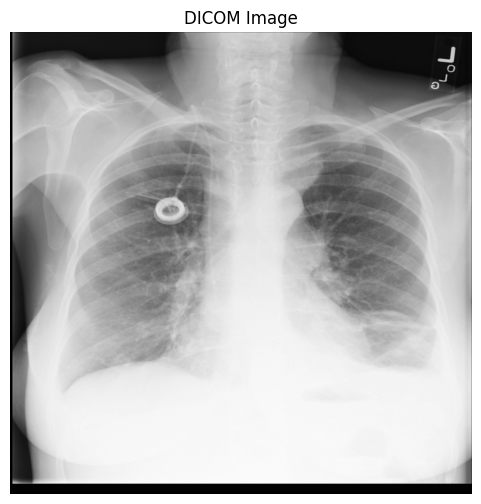

In [19]:
def visualize_dicom_image(dicom_data):
   
    img = dicom_data.pixel_array

    plt.figure(figsize=(6, 6))
    plt.imshow(img, cmap='gray')
    plt.title('DICOM Image')
    plt.axis('off') 
    plt.show()
    
visualize_dicom_image(dicom_data)

## CNN - Simple CNN

## CNN Model - transfer learning with resnet101



In [20]:
from sklearn.model_selection import train_test_split
from torchvision import transforms

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Read and process a subset (1000 samples) of the images and targets for modeling

In [21]:
X, y = read_and_resize_images(dataset[:1000])

Split the data into training and testing sets, and then transform them

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [23]:
img_size = 224

In [24]:
transform = transforms.Compose([
    transforms.ToPILImage(), 
    transforms.Resize((int(img_size), int(img_size))), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


In [25]:
import torch
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.models as models
import torch.nn as nn


PyTorch Dataset class that encapsulates the preprocessed images and corresponding labels

In [26]:
class PneumoniaDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels.astype(int)
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        label = torch.tensor(label, dtype=torch.long)

        return image, label


Create dataset and dataloader instances for training and testing


In [27]:
train_dataset = PneumoniaDataset(X_train, y_train, transform=transform)
test_dataset = PneumoniaDataset(X_test, y_test, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


Prepare the Pretrained ResNet101 model for fine-tuning, and set up the loss function and optimizer


In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet101 = models.resnet101(pretrained=True)
num_classes = 2  
resnet101.fc = nn.Linear(resnet101.fc.in_features, num_classes)
resnet101 = resnet101.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet101.parameters(), lr=0.001)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:00<00:00, 268MB/s]  


Training loop for the ResNet101 model with a set number of epochs

In [29]:
num_epochs = 10

train_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    resnet101.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = resnet101(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss}, Accuracy: {epoch_accuracy}%")


Epoch 1/10, Loss: 0.6334737873077393, Accuracy: 71.875%
Epoch 2/10, Loss: 0.46197805285453797, Accuracy: 79.875%
Epoch 3/10, Loss: 0.38770841956138613, Accuracy: 82.625%
Epoch 4/10, Loss: 0.34424505531787875, Accuracy: 84.625%
Epoch 5/10, Loss: 0.3227038812637329, Accuracy: 84.75%
Epoch 6/10, Loss: 0.2483337005972862, Accuracy: 89.875%
Epoch 7/10, Loss: 0.22155173599720002, Accuracy: 91.625%
Epoch 8/10, Loss: 0.20896513640880585, Accuracy: 93.0%
Epoch 9/10, Loss: 0.13789533510804175, Accuracy: 93.875%
Epoch 10/10, Loss: 0.10761914663016796, Accuracy: 95.75%


Plot the training loss and accuracy for visualization of training progress


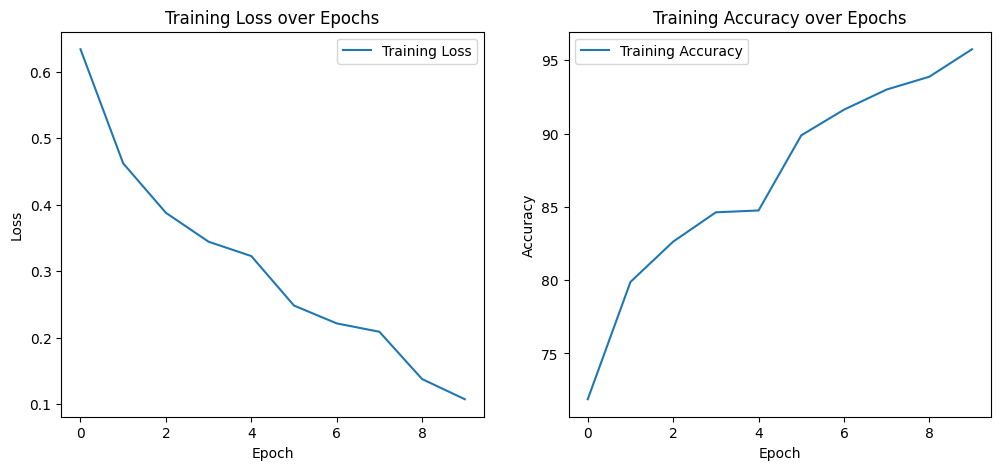

In [30]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.title('Training Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


Model evaluation to calculate the accuracy on the test set


In [31]:
resnet101 = resnet101.to(device)
resnet101.eval()  

correct = 0
total = 0
with torch.no_grad():  
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = resnet101(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy on the test set: {accuracy:.2f}%')

Accuracy on the test set: 65.00%


### Custom CNN


In [32]:
import torch.nn.functional as F


Define Simple CNN architecture for model building


In [33]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 56 * 56, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)  
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


Instantiate the SimpleCNN model and move it to the appropriate device (CPU or GPU)

In [34]:
model = SimpleCNN()
model = model.to(device)

Define loss function criterion and optimizer for the SimpleCNN

In [35]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Function to train the Custom CNN model with a training loop for the specified number of epochs

In [36]:
def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()
    train_losses = []
    train_accuracies = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = 100 * correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

    return train_losses, train_accuracies


In [37]:
num_epochs = 10 

In [38]:
train_losses, train_accuracies = train_model(model, train_loader, criterion, optimizer, num_epochs)


Epoch 1/10, Loss: 1.5960, Accuracy: 66.25%
Epoch 2/10, Loss: 0.4989, Accuracy: 76.00%
Epoch 3/10, Loss: 0.4160, Accuracy: 81.50%
Epoch 4/10, Loss: 0.3443, Accuracy: 86.38%
Epoch 5/10, Loss: 0.2509, Accuracy: 91.62%
Epoch 6/10, Loss: 0.1722, Accuracy: 93.62%
Epoch 7/10, Loss: 0.1234, Accuracy: 95.62%
Epoch 8/10, Loss: 0.1050, Accuracy: 95.88%
Epoch 9/10, Loss: 0.0548, Accuracy: 99.00%
Epoch 10/10, Loss: 0.0248, Accuracy: 99.38%


Plot training losses and accuracies

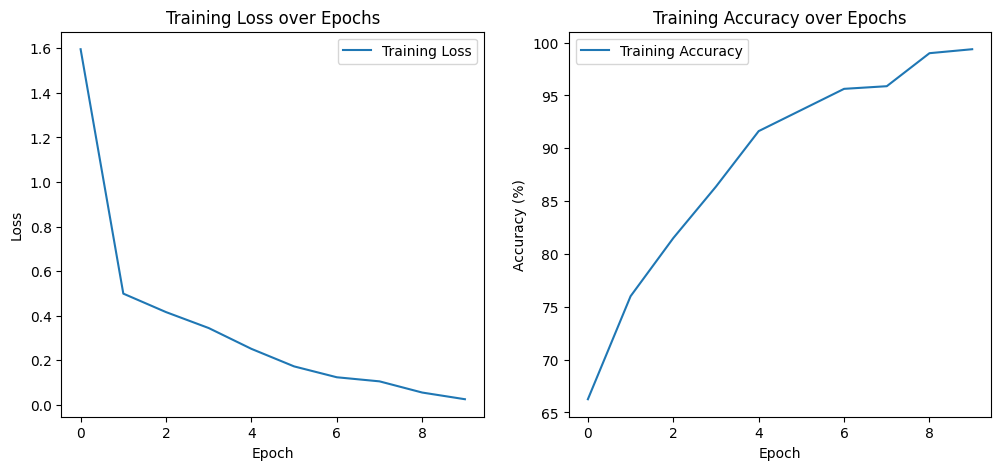

In [39]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.title('Training Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()

In [40]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

Evaluate the Custom CNN model and calculate the test set accuracy


In [41]:
def evaluate_model(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    accuracy = 100 * sum([1 for true, pred in zip(y_true, y_pred) if true == pred]) / len(y_true)
    print(f'Accuracy on test set: {accuracy:.2f}%')

    
evaluate_model(model, test_loader)

Accuracy on test set: 81.00%
